# Description

This notebook utilizes CLIP to steer BigGAN towards images that match a textual prompt.

It also dings.

## Using this notebook



Of note: this notebook comes with no guarantees that it will work for your prompt or at all, but it's free! There are many magical numbers and I'm sure there are better ways to regularize the latent code.


Images will be shown routinely in the "Train" cell after a "ding."


# Restart the kernel...

 and rerun all cells after running the cell below and setting your prompt.


**In the top menu press \<Runtime\> then \<Restart and run all\> to restart everything after this cell stops running**


In [ ]:
import subprocess

CUDA_version = [s for s in subprocess.check_output(["nvcc", "--version"]).decode("UTF-8").split(", ") if s.startswith("release")][0].split(" ")[-1]
print("CUDA version:", CUDA_version)

if CUDA_version == "10.0":
    torch_version_suffix = "+cu100"
elif CUDA_version == "10.1":
    torch_version_suffix = "+cu101"
elif CUDA_version == "10.2":
    torch_version_suffix = ""
else:
    torch_version_suffix = "+cu110"

!pip install torch==1.7.1{torch_version_suffix} torchvision==0.8.2{torch_version_suffix} -f https://download.pytorch.org/whl/torch_stable.html ftfy regex

CUDA version: 11.1
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |███████████████████████         | 834.1 MB 1.6 MB/s eta 0:03:19tcmalloc: large alloc 1147494400 bytes == 0x39d8e000 @  0x7fbc1c7cb615 0x592b76 0x4df71e 0x59afff 0x515655 0x549576 0x593fce 0x548ae9 0x51566f 0x549576 0x593fce 0x548ae9 0x5127f1 0x598e3b 0x511f68 0x598e3b 0x511f68 0x598e3b 0x511f68 0x4bc98a 0x532e76 0x594b72 0x515600 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576 0x593fce 0x5118f8 0x593dd7
     |█████████████████████████████▏  | 1055.7 MB 1.3 MB/s eta 0:01:21tcmalloc: large alloc 1434370048 bytes == 0x7e3e4000 @  0x7fbc1c7cb615 0x592b76 0x4df71e 0x59afff 0x515655 0x549576 0x593fce 0x548ae9 0x51566f 0x549576 0x593fce 0x548ae9 0x5127f1 0x598e3b 0x511f68 0x598e3b 0x511f68 0x598e3b 0x511f68 0x4bc98a 0x532e76 0x594b72 0x515600 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576 0x593fce 0x5118f8 0x593dd7
     |████████████████████████████████| 1156.7 MB 1.3 MB/s eta 0:00:01tcmalloc: large alloc

# Many Imports

Import the usual libraries

In [ ]:
import torch
import numpy as np
import torchvision
import torchvision.transforms.functional as TF

import PIL
import matplotlib.pyplot as plt

import os
import random
import imageio
from IPython import display
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import glob

from google.colab import output



In [ ]:
!nvidia-smi -L


GPU 0: Tesla K80 (UUID: GPU-d0c6e91f-7e0c-f114-17f9-98444c363357)


# Perceptor

Get and load up CLIP

In [ ]:


%cd /content/

!git clone https://github.com/openai/CLIP.git


%cd /content/CLIP/

!pip install ftfy

import os
import clip
import torch


import numpy as np

# Load the model
perceptor, preprocess = clip.load('ViT-B/32')


/content
Cloning into 'CLIP'...
remote: Enumerating objects: 222, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 222 (delta 0), reused 4 (delta 0), pack-reused 218
Receiving objects: 100% (222/222), 8.92 MiB | 12.72 MiB/s, done.
Resolving deltas: 100% (109/109), done.
/content/CLIP


100%|████████████████████████████████████████| 338M/338M [00:03<00:00, 103MiB/s]


# Parameters

Don't bother changing anything but the prompt below if you're not using a different type of BigGAN

In [ ]:
im_shape = [512, 512, 3]
sideX, sideY, channels = im_shape

tx = clip.tokenize('''a cityscape in the style of Van Gogh''')


# Define

Some helper functions

In [ ]:
def displ(img, pre_scaled=True):
  img = np.array(img)[:,:,:]
  img = np.transpose(img, (1, 2, 0))
  if not pre_scaled:
    img = scale(img, 48*4, 32*4)
  imageio.imwrite(str(3) + '.png', np.array(img))
  return display.Image(str(3)+'.png')

def gallery(array, ncols=2):
    nindex, height, width, intensity = array.shape
    nrows = nindex//ncols
    assert nindex == nrows*ncols
    # want result.shape = (height*nrows, width*ncols, intensity)
    result = (array.reshape(nrows, ncols, height, width, intensity)
              .swapaxes(1,2)
              .reshape(height*nrows, width*ncols, intensity))
    return result

def card_padded(im, to_pad=3):
  return np.pad(np.pad(np.pad(im, [[1,1], [1,1], [0,0]],constant_values=0), [[2,2], [2,2], [0,0]],constant_values=1),
            [[to_pad,to_pad], [to_pad,to_pad], [0,0]],constant_values=0)

def get_all(img):
  img = np.transpose(img, (0,2,3,1))
  cards = np.zeros((img.shape[0], sideX+12, sideY+12, 3))
  for i in range(len(img)):
    cards[i] = card_padded(img[i])
  print(img.shape)
  cards = gallery(cards)
  imageio.imwrite(str(3) + '.png', np.array(cards))
  return display.Image(str(3)+'.png')
  

# Generator

Alter BigGAN for multiple class & latent inputs



In [ ]:
!pip install pytorch-pretrained-biggan

import torch.nn as nn
import torch.nn.functional as F
import math
import json
import logging
import os
import shutil
import tempfile
from functools import wraps
from hashlib import sha256
import sys
from io import open

import boto3
import requests
from botocore.exceptions import ClientError
from tqdm import tqdm

try:
    from urllib.parse import urlparse
except ImportError:
    from urlparse import urlparse

try:
    from pathlib import Path
    PYTORCH_PRETRAINED_BIGGAN_CACHE = Path(os.getenv('PYTORCH_PRETRAINED_BIGGAN_CACHE',
                                                   Path.home() / '.pytorch_pretrained_biggan'))
except (AttributeError, ImportError):
    PYTORCH_PRETRAINED_BIGGAN_CACHE = os.getenv('PYTORCH_PRETRAINED_BIGGAN_CACHE',
                                              os.path.join(os.path.expanduser("~"), '.pytorch_pretrained_biggan'))

logger = logging.getLogger(__name__)  # pylint: disable=invalid-name


def url_to_filename(url, etag=None):
    """
    Convert `url` into a hashed filename in a repeatable way.
    If `etag` is specified, append its hash to the url's, delimited
    by a period.
    """
    url_bytes = url.encode('utf-8')
    url_hash = sha256(url_bytes)
    filename = url_hash.hexdigest()

    if etag:
        etag_bytes = etag.encode('utf-8')
        etag_hash = sha256(etag_bytes)
        filename += '.' + etag_hash.hexdigest()

    return filename


def filename_to_url(filename, cache_dir=None):
    """
    Return the url and etag (which may be ``None``) stored for `filename`.
    Raise ``EnvironmentError`` if `filename` or its stored metadata do not exist.
    """
    if cache_dir is None:
        cache_dir = PYTORCH_PRETRAINED_BIGGAN_CACHE
    if sys.version_info[0] == 3 and isinstance(cache_dir, Path):
        cache_dir = str(cache_dir)

    cache_path = os.path.join(cache_dir, filename)
    if not os.path.exists(cache_path):
        raise EnvironmentError("file {} not found".format(cache_path))

    meta_path = cache_path + '.json'
    if not os.path.exists(meta_path):
        raise EnvironmentError("file {} not found".format(meta_path))

    with open(meta_path, encoding="utf-8") as meta_file:
        metadata = json.load(meta_file)
    url = metadata['url']
    etag = metadata['etag']

    return url, etag


def cached_path(url_or_filename, cache_dir=None):
    """
    Given something that might be a URL (or might be a local path),
    determine which. If it's a URL, download the file and cache it, and
    return the path to the cached file. If it's already a local path,
    make sure the file exists and then return the path.
    """
    if cache_dir is None:
        cache_dir = PYTORCH_PRETRAINED_BIGGAN_CACHE
    if sys.version_info[0] == 3 and isinstance(url_or_filename, Path):
        url_or_filename = str(url_or_filename)
    if sys.version_info[0] == 3 and isinstance(cache_dir, Path):
        cache_dir = str(cache_dir)

    parsed = urlparse(url_or_filename)

    if parsed.scheme in ('http', 'https', 's3'):
        # URL, so get it from the cache (downloading if necessary)
        return get_from_cache(url_or_filename, cache_dir)
    elif os.path.exists(url_or_filename):
        # File, and it exists.
        return url_or_filename
    elif parsed.scheme == '':
        # File, but it doesn't exist.
        raise EnvironmentError("file {} not found".format(url_or_filename))
    else:
        # Something unknown
        raise ValueError("unable to parse {} as a URL or as a local path".format(url_or_filename))


def split_s3_path(url):
    """Split a full s3 path into the bucket name and path."""
    parsed = urlparse(url)
    if not parsed.netloc or not parsed.path:
        raise ValueError("bad s3 path {}".format(url))
    bucket_name = parsed.netloc
    s3_path = parsed.path
    # Remove '/' at beginning of path.
    if s3_path.startswith("/"):
        s3_path = s3_path[1:]
    return bucket_name, s3_path


def s3_request(func):
    """
    Wrapper function for s3 requests in order to create more helpful error
    messages.
    """

    @wraps(func)
    def wrapper(url, *args, **kwargs):
        try:
            return func(url, *args, **kwargs)
        except ClientError as exc:
            if int(exc.response["Error"]["Code"]) == 404:
                raise EnvironmentError("file {} not found".format(url))
            else:
                raise

    return wrapper


@s3_request
def s3_etag(url):
    """Check ETag on S3 object."""
    s3_resource = boto3.resource("s3")
    bucket_name, s3_path = split_s3_path(url)
    s3_object = s3_resource.Object(bucket_name, s3_path)
    return s3_object.e_tag


@s3_request
def s3_get(url, temp_file):
    """Pull a file directly from S3."""
    s3_resource = boto3.resource("s3")
    bucket_name, s3_path = split_s3_path(url)
    s3_resource.Bucket(bucket_name).download_fileobj(s3_path, temp_file)


def http_get(url, temp_file):
    req = requests.get(url, stream=True)
    content_length = req.headers.get('Content-Length')
    total = int(content_length) if content_length is not None else None
    progress = tqdm(unit="B", total=total)
    for chunk in req.iter_content(chunk_size=1024):
        if chunk: # filter out keep-alive new chunks
            progress.update(len(chunk))
            temp_file.write(chunk)
    progress.close()


def get_from_cache(url, cache_dir=None):
    """
    Given a URL, look for the corresponding dataset in the local cache.
    If it's not there, download it. Then return the path to the cached file.
    """
    if cache_dir is None:
        cache_dir = PYTORCH_PRETRAINED_BIGGAN_CACHE
    if sys.version_info[0] == 3 and isinstance(cache_dir, Path):
        cache_dir = str(cache_dir)

    if not os.path.exists(cache_dir):
        os.makedirs(cache_dir)

    # Get eTag to add to filename, if it exists.
    if url.startswith("s3://"):
        etag = s3_etag(url)
    else:
        response = requests.head(url, allow_redirects=True)
        if response.status_code != 200:
            raise IOError("HEAD request failed for url {} with status code {}"
                          .format(url, response.status_code))
        etag = response.headers.get("ETag")

    filename = url_to_filename(url, etag)

    # get cache path to put the file
    cache_path = os.path.join(cache_dir, filename)

    if not os.path.exists(cache_path):
        # Download to temporary file, then copy to cache dir once finished.
        # Otherwise you get corrupt cache entries if the download gets interrupted.
        with tempfile.NamedTemporaryFile() as temp_file:
            logger.info("%s not found in cache, downloading to %s", url, temp_file.name)

            # GET file object
            if url.startswith("s3://"):
                s3_get(url, temp_file)
            else:
                http_get(url, temp_file)

            # we are copying the file before closing it, so flush to avoid truncation
            temp_file.flush()
            # shutil.copyfileobj() starts at the current position, so go to the start
            temp_file.seek(0)

            logger.info("copying %s to cache at %s", temp_file.name, cache_path)
            with open(cache_path, 'wb') as cache_file:
                shutil.copyfileobj(temp_file, cache_file)

            logger.info("creating metadata file for %s", cache_path)
            meta = {'url': url, 'etag': etag}
            meta_path = cache_path + '.json'
            with open(meta_path, 'w', encoding="utf-8") as meta_file:
                json.dump(meta, meta_file)

            logger.info("removing temp file %s", temp_file.name)

    return cache_path


def read_set_from_file(filename):
    '''
    Extract a de-duped collection (set) of text from a file.
    Expected file format is one item per line.
    '''
    collection = set()
    with open(filename, 'r', encoding='utf-8') as file_:
        for line in file_:
            collection.add(line.rstrip())
    return collection


def get_file_extension(path, dot=True, lower=True):
    ext = os.path.splitext(path)[1]
    ext = ext if dot else ext[1:]
    return ext.lower() if lower else ext


PRETRAINED_MODEL_ARCHIVE_MAP = {
    'biggan-deep-128': "https://s3.amazonaws.com/models.huggingface.co/biggan/biggan-deep-128-pytorch_model.bin",
    'biggan-deep-256': "https://s3.amazonaws.com/models.huggingface.co/biggan/biggan-deep-256-pytorch_model.bin",
    'biggan-deep-512': "https://s3.amazonaws.com/models.huggingface.co/biggan/biggan-deep-512-pytorch_model.bin",
}

PRETRAINED_CONFIG_ARCHIVE_MAP = {
    'biggan-deep-128': "https://s3.amazonaws.com/models.huggingface.co/biggan/biggan-deep-128-config.json",
    'biggan-deep-256': "https://s3.amazonaws.com/models.huggingface.co/biggan/biggan-deep-256-config.json",
    'biggan-deep-512': "https://s3.amazonaws.com/models.huggingface.co/biggan/biggan-deep-512-config.json",
}

WEIGHTS_NAME = 'pytorch_model.bin'
CONFIG_NAME = 'config.json'
import copy
import json

class BigGANConfig(object):
    """ Configuration class to store the configuration of a `BigGAN`. 
        Defaults are for the 128x128 model.
        layers tuple are (up-sample in the layer ?, input channels, output channels)
    """
    def __init__(self,
                 output_dim=128,
                 z_dim=128,
                 class_embed_dim=128,
                 channel_width=128,
                 num_classes=1000,
                 layers=[(False, 16, 16),
                         (True, 16, 16),
                         (False, 16, 16),
                         (True, 16, 8),
                         (False, 8, 8),
                         (True, 8, 4),
                         (False, 4, 4),
                         (True, 4, 2),
                         (False, 2, 2),
                         (True, 2, 1)],
                 attention_layer_position=8,
                 eps=1e-4,
                 n_stats=51):
        """Constructs BigGANConfig. """
        self.output_dim = output_dim
        self.z_dim = z_dim
        self.class_embed_dim = class_embed_dim
        self.channel_width = channel_width
        self.num_classes = num_classes
        self.layers = layers
        self.attention_layer_position = attention_layer_position
        self.eps = eps
        self.n_stats = n_stats

    @classmethod
    def from_dict(cls, json_object):
        """Constructs a `BigGANConfig` from a Python dictionary of parameters."""
        config = BigGANConfig()
        for key, value in json_object.items():
            config.__dict__[key] = value
        return config

    @classmethod
    def from_json_file(cls, json_file):
        """Constructs a `BigGANConfig` from a json file of parameters."""
        with open(json_file, "r", encoding='utf-8') as reader:
            text = reader.read()
        return cls.from_dict(json.loads(text))

    def __repr__(self):
        return str(self.to_json_string())

    def to_dict(self):
        """Serializes this instance to a Python dictionary."""
        output = copy.deepcopy(self.__dict__)
        return output

    def to_json_string(self):
        """Serializes this instance to a JSON string."""
        return json.dumps(self.to_dict(), indent=2, sort_keys=True) + "\n"







def snconv2d(eps=1e-12, **kwargs):
    return nn.utils.spectral_norm(nn.Conv2d(**kwargs), eps=eps)

def snlinear(eps=1e-12, **kwargs):
    return nn.utils.spectral_norm(nn.Linear(**kwargs), eps=eps)

def sn_embedding(eps=1e-12, **kwargs):
    return nn.utils.spectral_norm(nn.Embedding(**kwargs), eps=eps)

class SelfAttn(nn.Module):
    """ Self attention Layer"""
    def __init__(self, in_channels, eps=1e-12):
        super(SelfAttn, self).__init__()
        self.in_channels = in_channels
        self.snconv1x1_theta = snconv2d(in_channels=in_channels, out_channels=in_channels//8,
                                        kernel_size=1, bias=False, eps=eps)
        self.snconv1x1_phi = snconv2d(in_channels=in_channels, out_channels=in_channels//8,
                                      kernel_size=1, bias=False, eps=eps)
        self.snconv1x1_g = snconv2d(in_channels=in_channels, out_channels=in_channels//2,
                                    kernel_size=1, bias=False, eps=eps)
        self.snconv1x1_o_conv = snconv2d(in_channels=in_channels//2, out_channels=in_channels,
                                         kernel_size=1, bias=False, eps=eps)
        self.maxpool = nn.MaxPool2d(2, stride=2, padding=0)
        self.softmax  = nn.Softmax(dim=-1)
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        _, ch, h, w = x.size()
        # Theta path
        theta = self.snconv1x1_theta(x)
        theta = theta.view(-1, ch//8, h*w)
        # Phi path
        phi = self.snconv1x1_phi(x)
        phi = self.maxpool(phi)
        phi = phi.view(-1, ch//8, h*w//4)
        # Attn map
        attn = torch.bmm(theta.permute(0, 2, 1), phi)
        attn = self.softmax(attn)
        # g path
        g = self.snconv1x1_g(x)
        g = self.maxpool(g)
        g = g.view(-1, ch//2, h*w//4)
        # Attn_g - o_conv
        attn_g = torch.bmm(g, attn.permute(0, 2, 1))
        attn_g = attn_g.view(-1, ch//2, h, w)
        attn_g = self.snconv1x1_o_conv(attn_g)
        # Out
        out = x + self.gamma*attn_g
        return out


class BigGANBatchNorm(nn.Module):
    """ This is a batch norm module that can handle conditional input and can be provided with pre-computed
        activation means and variances for various truncation parameters.
        We cannot just rely on torch.batch_norm since it cannot handle
        batched weights (pytorch 1.0.1). We computate batch_norm our-self without updating running means and variances.
        If you want to train this model you should add running means and variance computation logic.
    """
    def __init__(self, num_features, condition_vector_dim=None, n_stats=51, eps=1e-4, conditional=True):
        super(BigGANBatchNorm, self).__init__()
        self.num_features = num_features
        self.eps = eps
        self.conditional = conditional

        # We use pre-computed statistics for n_stats values of truncation between 0 and 1
        self.register_buffer('running_means', torch.zeros(n_stats, num_features))
        self.register_buffer('running_vars', torch.ones(n_stats, num_features))
        self.step_size = 1.0 / (n_stats - 1)

        if conditional:
            assert condition_vector_dim is not None
            self.scale = snlinear(in_features=condition_vector_dim, out_features=num_features, bias=False, eps=eps)
            self.offset = snlinear(in_features=condition_vector_dim, out_features=num_features, bias=False, eps=eps)
        else:
            self.weight = torch.nn.Parameter(torch.Tensor(num_features))
            self.bias = torch.nn.Parameter(torch.Tensor(num_features))

    def forward(self, x, truncation, condition_vector=None):
        # Retreive pre-computed statistics associated to this truncation
        coef, start_idx = math.modf(truncation / self.step_size)
        start_idx = int(start_idx)
        if coef != 0.0:  # Interpolate
            running_mean = self.running_means[start_idx] * coef + self.running_means[start_idx + 1] * (1 - coef)
            running_var = self.running_vars[start_idx] * coef + self.running_vars[start_idx + 1] * (1 - coef)
        else:
            running_mean = self.running_means[start_idx]
            running_var = self.running_vars[start_idx]

        if self.conditional:
            running_mean = running_mean.unsqueeze(0).unsqueeze(-1).unsqueeze(-1)
            running_var = running_var.unsqueeze(0).unsqueeze(-1).unsqueeze(-1)

            weight = 1 + self.scale(condition_vector).unsqueeze(-1).unsqueeze(-1)
            bias = self.offset(condition_vector).unsqueeze(-1).unsqueeze(-1)

            out = (x - running_mean) / torch.sqrt(running_var + self.eps) * weight + bias
        else:
            out = F.batch_norm(x, running_mean, running_var, self.weight, self.bias,
                               training=False, momentum=0.0, eps=self.eps)

        return out


class GenBlock(nn.Module):
    def __init__(self, in_size, out_size, condition_vector_dim, reduction_factor=4, up_sample=False,
                 n_stats=51, eps=1e-12):
        super(GenBlock, self).__init__()
        self.up_sample = up_sample
        self.drop_channels = (in_size != out_size)
        middle_size = in_size // reduction_factor

        self.bn_0 = BigGANBatchNorm(in_size, condition_vector_dim, n_stats=n_stats, eps=eps, conditional=True)
        self.conv_0 = snconv2d(in_channels=in_size, out_channels=middle_size, kernel_size=1, eps=eps)

        self.bn_1 = BigGANBatchNorm(middle_size, condition_vector_dim, n_stats=n_stats, eps=eps, conditional=True)
        self.conv_1 = snconv2d(in_channels=middle_size, out_channels=middle_size, kernel_size=3, padding=1, eps=eps)

        self.bn_2 = BigGANBatchNorm(middle_size, condition_vector_dim, n_stats=n_stats, eps=eps, conditional=True)
        self.conv_2 = snconv2d(in_channels=middle_size, out_channels=middle_size, kernel_size=3, padding=1, eps=eps)

        self.bn_3 = BigGANBatchNorm(middle_size, condition_vector_dim, n_stats=n_stats, eps=eps, conditional=True)
        self.conv_3 = snconv2d(in_channels=middle_size, out_channels=out_size, kernel_size=1, eps=eps)

        self.relu = nn.ReLU()

    def forward(self, x, cond_vector, truncation):
        x0 = x

        x = self.bn_0(x, truncation, cond_vector)
        x = self.relu(x)
        x = self.conv_0(x)

        x = self.bn_1(x, truncation, cond_vector)
        x = self.relu(x)
        if self.up_sample:
            x = F.interpolate(x, scale_factor=2, mode='nearest')
        x = self.conv_1(x)

        x = self.bn_2(x, truncation, cond_vector)
        x = self.relu(x)
        x = self.conv_2(x)

        x = self.bn_3(x, truncation, cond_vector)
        x = self.relu(x)
        x = self.conv_3(x)

        if self.drop_channels:
            new_channels = x0.shape[1] // 2
            x0 = x0[:, :new_channels, ...]
        if self.up_sample:
            x0 = F.interpolate(x0, scale_factor=2, mode='nearest')

        out = x + x0
        return out

class Generator(nn.Module):
    def __init__(self, config):
        super(Generator, self).__init__()
        self.config = config
        ch = config.channel_width
        condition_vector_dim = config.z_dim * 2

        self.gen_z = snlinear(in_features=condition_vector_dim,
                              out_features=4 * 4 * 16 * ch, eps=config.eps)

        layers = []
        for i, layer in enumerate(config.layers):
            if i == config.attention_layer_position:
                layers.append(SelfAttn(ch*layer[1], eps=config.eps))
            layers.append(GenBlock(ch*layer[1],
                                   ch*layer[2],
                                   condition_vector_dim,
                                   up_sample=layer[0],
                                   n_stats=config.n_stats,
                                   eps=config.eps))
        self.layers = nn.ModuleList(layers)

        self.bn = BigGANBatchNorm(ch, n_stats=config.n_stats, eps=config.eps, conditional=False)
        self.relu = nn.ReLU()
        self.conv_to_rgb = snconv2d(in_channels=ch, out_channels=ch, kernel_size=3, padding=1, eps=config.eps)
        self.tanh = nn.Tanh()

    def forward(self, cond_vector, truncation):
        z = self.gen_z(cond_vector[0].unsqueeze(0))

        # We use this conversion step to be able to use TF weights:
        # TF convention on shape is [batch, height, width, channels]
        # PT convention on shape is [batch, channels, height, width]
        z = z.view(-1, 4, 4, 16 * self.config.channel_width)
        z = z.permute(0, 3, 1, 2).contiguous()

        for i, layer in enumerate(self.layers):
            if isinstance(layer, GenBlock):
                z = layer(z, cond_vector[i+1].unsqueeze(0), truncation)
                # z = layer(z, cond_vector[].unsqueeze(0), truncation)
            else:
                z = layer(z)

        z = self.bn(z, truncation)
        z = self.relu(z)
        z = self.conv_to_rgb(z)
        z = z[:, :3, ...]
        z = self.tanh(z)
        return z

class BigGAN(nn.Module):
    """BigGAN Generator."""

    @classmethod
    def from_pretrained(cls, pretrained_model_name_or_path, cache_dir=None, *inputs, **kwargs):
        if pretrained_model_name_or_path in PRETRAINED_MODEL_ARCHIVE_MAP:
            model_file = PRETRAINED_MODEL_ARCHIVE_MAP[pretrained_model_name_or_path]
            config_file = PRETRAINED_CONFIG_ARCHIVE_MAP[pretrained_model_name_or_path]
        else:
            model_file = os.path.join(pretrained_model_name_or_path, WEIGHTS_NAME)
            config_file = os.path.join(pretrained_model_name_or_path, CONFIG_NAME)

        try:
            resolved_model_file = cached_path(model_file, cache_dir=cache_dir)
            resolved_config_file = cached_path(config_file, cache_dir=cache_dir)
        except EnvironmentError:
            logger.error("Wrong model name, should be a valid path to a folder containing "
                         "a {} file and a {} file or a model name in {}".format(
                         WEIGHTS_NAME, CONFIG_NAME, PRETRAINED_MODEL_ARCHIVE_MAP.keys()))
            raise

        logger.info("loading model {} from cache at {}".format(pretrained_model_name_or_path, resolved_model_file))

        # Load config
        config = BigGANConfig.from_json_file(resolved_config_file)
        logger.info("Model config {}".format(config))

        # Instantiate model.
        model = cls(config, *inputs, **kwargs)
        state_dict = torch.load(resolved_model_file, map_location='cpu' if not torch.cuda.is_available() else None)
        model.load_state_dict(state_dict, strict=False)
        return model

    def __init__(self, config):
        super(BigGAN, self).__init__()
        self.config = config
        self.embeddings = nn.Linear(config.num_classes, config.z_dim, bias=False)
        self.generator = Generator(config)

    def forward(self, z, class_label, truncation):
        assert 0 < truncation <= 1

        embed = self.embeddings(class_label)
        cond_vector = torch.cat((z, embed), dim=1)

        z = self.generator(cond_vector, truncation)
        return z



model = BigGAN.from_pretrained('biggan-deep-512')
model = model.cuda().eval()


def one_hot_from_int(int_or_list, batch_size=1):
    """ Create a one-hot vector from a class index or a list of class indices.
        Params:
            int_or_list: int, or list of int, of the imagenet classes (between 0 and 999)
            batch_size: batch size.
                If int_or_list is an int create a batch of identical classes.
                If int_or_list is a list, we should have `len(int_or_list) == batch_size`
        Output:
            array of shape (batch_size, 1000)
    """
    if isinstance(int_or_list, int):
        int_or_list = [int_or_list]

    if len(int_or_list) == 1 and batch_size > 1:
        int_or_list = [int_or_list[0]] * batch_size

    assert batch_size == len(int_or_list)

    array = np.zeros((batch_size, 1000), dtype=np.float32)
    for i, j in enumerate(int_or_list):
        array[i, j] = 1.0
    return array


     |████████████████████████████████| 132 kB 5.2 MB/s 
     |████████████████████████████████| 79 kB 6.8 MB/s 
     |████████████████████████████████| 8.7 MB 2.2 MB/s 
     |████████████████████████████████| 138 kB 46.5 MB/s 
     |████████████████████████████████| 127 kB 49.2 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


100%|██████████| 800/800 [00:00<00:00, 278506.24B/s]


# Latent coordinate

Choose a place to start in BigGAN (it'll be a dog. Probably a hound lol)

(Parameter containing:
tensor([[-1.1258e+00, -1.1524e+00, -2.5058e-01,  ...,  1.1648e+00,
          9.2337e-01,  1.3873e+00],
        [-8.8338e-01, -4.1891e-01, -8.0483e-01,  ...,  1.4474e-01,
          1.9029e+00,  3.9040e-01],
        [-3.9373e-02, -8.0147e-01, -4.9554e-01,  ...,  5.5412e-01,
         -1.8166e-01, -2.3447e-01],
        ...,
        [ 1.6598e+00,  1.7719e-01, -1.9280e-03,  ..., -1.7596e-01,
          1.2778e+00,  1.0525e+00],
        [-3.3631e-01, -1.7877e-01, -9.9753e-01,  ..., -1.0989e+00,
         -2.1547e-01,  3.3639e-01],
        [ 5.9011e-01, -8.3249e-01, -1.3715e+00,  ..., -3.0357e+00,
         -1.7288e+00,  6.0198e-01]], device='cuda:0', requires_grad=True), tensor([[0.0350, 0.0267, 0.0193,  ..., 0.0383, 0.0157, 0.0128],
        [0.0212, 0.0277, 0.0160,  ..., 0.0178, 0.0299, 0.0195],
        [0.0234, 0.0123, 0.0219,  ..., 0.0169, 0.0226, 0.0167],
        ...,
        [0.0148, 0.0184, 0.0141,  ..., 0.0266, 0.0226, 0.0160],
        [0.0309, 0.0207, 0.0247,  ...,

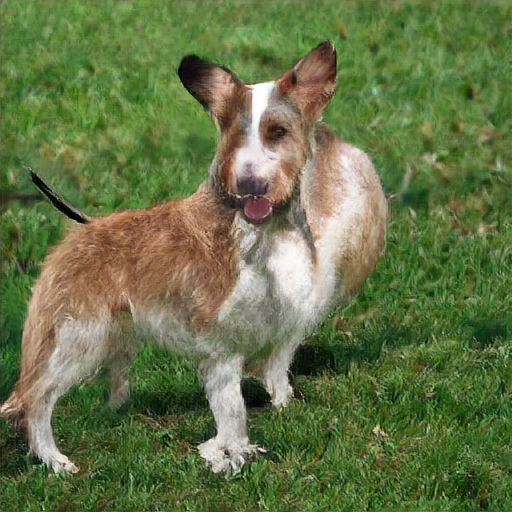

In [ ]:
class Pars(torch.nn.Module):
    def __init__(self):
        super(Pars, self).__init__()
        # params = torch.zeros(32, 1).normal_(std=1)

        # self.stds = torch.nn.Parameter(params)

        # params = torch.zeros(32, 1).normal_(std=.1)
        # self.means = torch.nn.Parameter(params)
        
        self.normu = torch.nn.Parameter(torch.zeros(32, 128).normal_(std=1).cuda())


        params_other = torch.zeros(32, 1000).normal_(-3.9, .3)
        self.cls = torch.nn.Parameter(params_other)

        self.thrsh_lat = torch.tensor(1).cuda()

        self.thrsh_cls = torch.tensor(1.9).cuda()



    def forward(self):
      # return self.ff2(self.ff1(self.latent_code)), torch.softmax(1000*self.ff4(self.ff3(self.cls)), -1)
      return self.normu, torch.sigmoid(self.cls)


torch.manual_seed(0)


lats = Pars().cuda()
optimizer = torch.optim.Adam(lats.parameters(), .07)
eps = 0

nom = torchvision.transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
t = perceptor.encode_text(tx.cuda()).detach().clone()

with torch.no_grad():
  al = (model(*lats(), 1).cpu()).numpy()
  print(lats())
  for allls in al:
    displ(allls)
    print('\n')

In [ ]:
pip install big-sleep

     |████████████████████████████████| 1.4 MB 4.1 MB/s 
     |████████████████████████████████| 87 kB 7.2 MB/s 
  Created wheel for fire: filename=fire-0.4.0-py2.py3-none-any.whl size=115942 sha256=1f54932c050a627eb11e4b437379698688d5e3a02ead0325275b5aaebaa0262b
  Stored in directory: /root/.cache/pip/wheels/8a/67/fb/2e8a12fa16661b9d5af1f654bd199366799740a85c64981226
Successfully built fire


In [ ]:
from big_sleep import Imagine

dream = Imagine(
    text = "fire in the sky",
    lr = 5e-2,
    save_every = 25,
    save_progress = True
)

dream()

Imagining "fire_in_the_sky" ...




loss: -18.27:   2%|▏         | 24/1050 [02:33<1:49:17,  6.39s/it]

image update:   0%|          | 1/840.0 [02:42<37:47:26, 162.15s/it]
loss: -21.59:   5%|▍         | 49/1050 [05:14<1:45:32,  6.33s/it]

image update:   0%|          | 2/840.0 [05:23<37:34:23, 161.41s/it]
loss: -24.07:   7%|▋         | 74/1050 [07:55<1:43:34,  6.37s/it]

image update:   0%|          | 3/840.0 [08:04<37:31:45, 161.42s/it]
loss: -26.22:   9%|▉         | 99/1050 [10:37<1:41:08,  6.38s/it]

image update:   0%|          | 4/840.0 [10:46<37:33:27, 161.73s/it]
loss: -27.50:  12%|█▏        | 124/1050 [13:19<1:38:33,  6.39s/it]

image update:   1%|          | 5/840.0 [13:28<37:33:13, 161.91s/it]
loss: -28.24:  14%|█▍        | 149/1050 [16:02<1:35:42,  6.37s/it]

image update:   1%|          | 6/840.0 [16:11<37:31:41, 161.99s/it]
loss: -28.56:  17%|█▋        | 174/1050 [18:43<1:33:10,  6.38s/it]

image update:   1%|          | 7/840.0 [18:52<37:28:14, 161.94s/it]
loss: -28.61:  19%|█▉        | 199/1050 [21:26<1:3

detecting keyboard interrupt, gracefully exiting


# Train

Train and generate samples

[tensor(4.5558, device='cuda:0', grad_fn=<AddBackward0>), tensor(1.1542, device='cuda:0', grad_fn=<MeanBackward0>), tensor(-14.1953, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)]


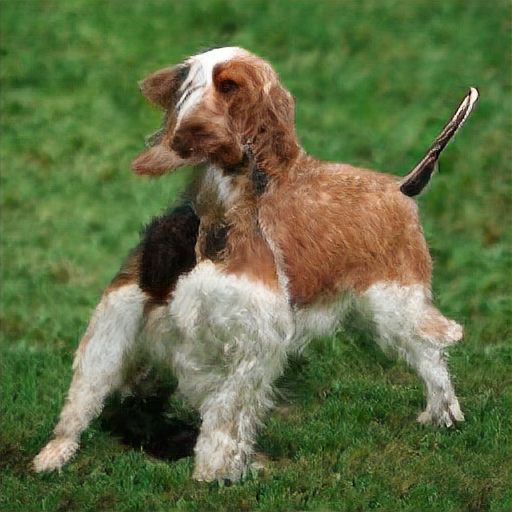

KeyboardInterrupt: ignored

In [ ]:



def checkin(loss):
  print(loss)
  best = torch.topk(loss[2], k=1, largest=False)[1]
  with torch.no_grad():
    al = model(*lats(), 1)[best:best+1].cpu().numpy()
  for allls in al:
    displ(allls)
    display.display(display.Image(str(3)+'.png'))
    print('\n')
  output.eval_js('new Audio("https://freesound.org/data/previews/80/80921_1022651-lq.ogg").play()')


def ascend_txt():
  out = model(*lats(), 1)

  cutn = 128
  p_s = []
  for ch in range(cutn):
    size = int(sideX*torch.zeros(1,).normal_(mean=.8, std=.3).clip(.5, .95))
    offsetx = torch.randint(0, sideX - size, ())
    offsety = torch.randint(0, sideX - size, ())
    apper = out[:, :, offsetx:offsetx + size, offsety:offsety + size]
    apper = torch.nn.functional.interpolate(apper, (224,224), mode='nearest')
    p_s.append(apper)
  into = torch.cat(p_s, 0)
  # into = torch.nn.functional.interpolate(out, (224,224), mode='nearest')

  into = nom((into + 1) / 2)
  
  iii = perceptor.encode_image(into)


  llls = lats()

  
  lat_l = torch.abs(1 - torch.std(llls[0], dim=1)).mean() + \
  torch.abs(torch.mean(llls[0])).mean() + \
  4*torch.max(torch.square(llls[0]).mean(), lats.thrsh_lat)


  for array in llls[0]:
    mean = torch.mean(array)
    diffs = array - mean
    var = torch.mean(torch.pow(diffs, 2.0))
    std = torch.pow(var, 0.5)
    zscores = diffs / std
    skews = torch.mean(torch.pow(zscores, 3.0))
    kurtoses = torch.mean(torch.pow(zscores, 4.0)) - 3.0

    lat_l = lat_l + torch.abs(kurtoses) / llls[0].shape[0] + torch.abs(skews) / llls[0].shape[0]


  

  cls_l = ((50*torch.topk(llls[1],largest=False,dim=1,k=999)[0])**2).mean()





  return [lat_l, cls_l, -100*torch.cosine_similarity(t, iii, dim=-1).mean()]

def train(epoch, i):
  loss1 = ascend_txt()
  loss = loss1[0] + loss1[1] + loss1[2]
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  

  
  
  if itt % 100 == 0:
    checkin(loss1)


itt = 0
for epochs in range(10000):
  for i in range(50000):
    train(eps, i)
    itt+=1
  eps+=1



In [ ]:
from big_sleep import Imagine

dream = Imagine(
    text = "fire in the sky",
    lr = 5e-2,
    save_every = 25,
    save_progress = True
)

dream()

# Diagnostics

If things don't work, try tweaking the learning rate. If that doesn't work, tweak the losses or even try changing the torch manual seed. The graphs below show the distributions of the class and latent vectors.

In [ ]:
with torch.no_grad():
  al = model(lats()[0], torch.zeros_like(lats()[1]), 1).cpu().numpy()
for allls in al:
  displ(allls)
  print('\n')

with torch.no_grad():
  al = model(torch.zeros_like(lats()[0]).normal_(), lats()[1], 1).cpu().numpy()
for allls in al:
  displ(allls)
  print('\n')


with torch.no_grad():
  these = tuple((lats()[0][:1].expand(32, -1), lats()[1][:1].expand(32, -1)))
  al = model(*these, 1).cpu().numpy()
for allls in al:
  displ(allls)
  print('\n')


In [ ]:
import matplotlib.pyplot as plt

with torch.no_grad():
  plt.close()
  th = plt.hist(lats()[0].detach().cpu().numpy().tolist())
  plt.show(th)
  plt.close()

  plt.show(plt.hist(lats()[1].detach().cpu().numpy().tolist()))
  print(torch.mean(lats()[0]))
  print(torch.mean(lats()[1]))
  print(lats()[0])
  print(lats()[1])

In [ ]:
with torch.no_grad():
  al = nom((1 + model(*lats(), 1).cpu()) / 2).numpy()
  for allls in al:
    displ(allls)
    print('\n')

# Bottom

In [ ]:

tx = clip.tokenize("eros")
im = (torch.tensor(np.array(PIL.Image.open('/content/eros.png'))).unsqueeze(0)/255).permute(0,3,1,2)
im = (torch.nn.functional.interpolate(im, (224, 224)) - .45) / .22
perceptor(im.cuda(), tx.cuda())[0]